In [66]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import json
import random
from collections import defaultdict
from collections import Counter

In [67]:
with open(file) as infile:
    for line in infile:
        data = json.loads(line)
        print(data)
        break

{'reviewerName': 'Steven N Elich', 'helpful': [0, 0], 'reviewText': "It is and does exactly what the description said it would be and would do. Couldn't be happier with it.", 'reviewerID': 'A00000262KYZUE4J55XGL', 'summary': "Does what it's supposed to do", 'unixReviewTime': 1353456000, 'overall': 5.0, 'reviewTime': '11 21, 2012', 'asin': 'B003UYU16G'}


In [73]:
def get_data(file='aggressive_dedup.json', year='2001', limit=1000000, size=10000):
    data = defaultdict(list)
    ratings = defaultdict(list)
    seen = {}
    
    with open(file) as infile:
        i = 0
        for line in infile:
            x = json.loads(line)
            yr = x['reviewTime'][-4:]
            rt = int(x.get('overall'))
            if yr >= year:
                if yr not in seen:
                    seen[yr] = 1
                else:
                    seen[yr] += 1
                if len(data[yr]) < size:
                    data[yr].append(x.get('reviewText'))
                    ratings[yr].append(rt)
                else:
                    if np.random.uniform() < size/seen[yr]:
                        p = np.random.randint(size)
                        data[yr][p] = x.get('reviewText')
                        ratings[yr][p] = rt            
            i += 1
            if i > limit:
                break
    return data, ratings

In [74]:
data, ratings = get_data()

for key in data.keys():
    print(key, '>>>', len(data[key]))

2001 >>> 6718
2003 >>> 7523
2012 >>> 10000
2006 >>> 10000
2007 >>> 10000
2011 >>> 10000
2013 >>> 10000
2002 >>> 6929
2010 >>> 10000
2014 >>> 10000
2009 >>> 10000
2008 >>> 10000
2005 >>> 10000
2004 >>> 9275


In [75]:
x = sorted(list(data.keys()))
for each in x:
    print(np.round(np.array(list((Counter(ratings[each]).values())))/len(ratings[each]), 2))

[0.06 0.05 0.09 0.21 0.59]
[0.06 0.05 0.08 0.2  0.61]
[0.08 0.06 0.09 0.2  0.58]
[0.09 0.06 0.08 0.2  0.57]
[0.11 0.06 0.08 0.18 0.56]
[0.1  0.06 0.09 0.19 0.56]
[0.07 0.05 0.08 0.2  0.6 ]
[0.08 0.05 0.08 0.2  0.59]
[0.09 0.05 0.09 0.19 0.58]
[0.1  0.06 0.09 0.19 0.57]
[0.11 0.06 0.09 0.18 0.56]
[0.09 0.05 0.09 0.18 0.59]
[0.08 0.05 0.08 0.19 0.6 ]
[0.08 0.05 0.09 0.18 0.61]


In [70]:
x = sorted(list(data.keys()))
for each in x:
    print(np.round(np.array(list((Counter(ratings[each]).values())))/len(ratings[each]), 2))

[0.04 0.06 0.08 0.21 0.61]
[0.06 0.05 0.08 0.2  0.6 ]
[0.07 0.04 0.08 0.19 0.61]
[0.09 0.06 0.09 0.2  0.56]
[0.11 0.06 0.1  0.2  0.53]
[0.09 0.06 0.09 0.19 0.56]
[0.06 0.04 0.08 0.21 0.61]
[0.08 0.05 0.08 0.21 0.56]
[0.08 0.05 0.09 0.2  0.57]
[0.09 0.05 0.08 0.21 0.57]
[0.09 0.06 0.09 0.22 0.54]
[0.08 0.06 0.08 0.2  0.59]
[0.06 0.05 0.08 0.21 0.6 ]
[0.06 0.06 0.08 0.17 0.63]


['1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014'] [165, 846, 2384, 7044, 6718, 6929, 7523, 9275, 12476, 14058, 22371, 25063, 32369, 41851, 67920, 140386, 354659, 247964]


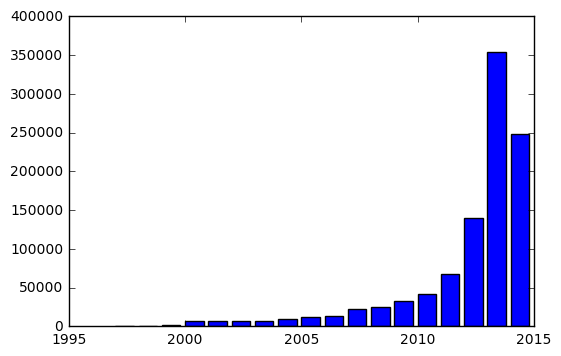

In [67]:
x = sorted(list(data.keys()))
y = [years.get(yr) for yr in x]

print(x, y)

plt.bar(x, y)
plt.show()